In [2]:
# HIDDEN

from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [3]:
# HIDDEN

# Construct a 52-card deck
from itertools import product

ranks = ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K']
suits = ['♠︎', '♥︎', '♦︎', '♣︎']
cards = product(ranks, suits)

deck = Table(['rank', 'suit']).with_rows(cards)

## Repetition

It is often the case when programming that you will wish to repeat the same operation multiple times, perhaps with slightly different behavior each time.  You could copy-paste the code 10 times, but that's tedious and prone to typos, and if you wanted to do it a thousand times (or a million times), forget it.  

A better solution is to use a `for` statement to loop over the contents of a sequence. A `for` statement begins with the word `for`, followed by a name for the item in the sequence, followed by the word `in`, and ending with an expression that evaluates to a sequence. The indented body of the `for` statement is executed once *for each item in that sequence*.

In [5]:
for i in np.arange(5):
    print(i)

0
1
2
3
4


A typical use of a `for` statement is to build up a table by repeating a random computation many times and storing each result as a new row. The `append` method of a table takes a sequence and adds a new row. It's different from `with_row` because a new table is not created; instead, the original table is extended. 

In [17]:
t = Table(['Up to ten', 'Up to twenty'])
for i in np.arange(8):
    t.append([np.random.randint(10), np.random.randint(20)])
t

Up to ten,Up to twenty
7,10
9,7
5,19
8,3
0,12
8,17
8,18
1,17


This pattern can be used to track the results of repeated experiments. For example, perhaps we want to learn about the empirical properties of some randomly drawn poker hands. Below, we track whether the hand contains 2-, 3-, or 4-of-a-kind and whether all cards have the same suit.

In [19]:
hands = Table(['Pair', 'Three-of-a-kind', 'Four-of-a-kind', 'Flush'])
for i in np.arange(10000):
    hand = deck.sample(5)
    max_same = max(hand.group('rank').column('count'))
    is_flush = hand.group('suit').num_rows == 1
    hands.append([max_same >= 2, max_same >= 3, max_same >= 4, is_flush])
hands

Pair,Three-of-a-kind,Four-of-a-kind,Flush
True,False,False,False
True,False,False,False
True,False,False,False
False,False,False,False
True,False,False,False
False,False,False,False
False,False,False,False
False,False,False,False
True,False,False,False
False,False,False,False


A `for` statement can also iterate over a sequence of labels. We can use this feature to summarize the results of our experiment.

In [21]:
for label in hands.labels:
    success = np.count_nonzero(hands.column(label))
    print('A', label, 'was drawn', success, 'of', hands.num_rows, 'times')

A Pair was drawn 4952 of 10000 times
A Three-of-a-kind was drawn 250 of 10000 times
A Four-of-a-kind was drawn 4 of 10000 times
A Flush was drawn 18 of 10000 times


## Randomized response

Next, we'll look at a technique that was designed several decades ago to help conduct surveys of sensitive subjects.  Researchers wanted to ask participants a few questions: Have you ever had an affair?  Do you secretly think you are gay?  Have you ever shoplifted?  Have you ever sung a Justin Bieber song in the shower?  They figured that some people might not respond honestly, because of the social stigma associated with answering "yes".  So, they came up with a clever way to estimate the fraction of the population who are in the "yes" camp, without violating anyone's privacy.

Here's the idea.  We'll instruct the respondent to roll a fair 6-sided die, secretly, where no one else can see it.  If the die comes up 1, 2, 3, or 4, then respondent is supposed to answer honestly.  If it comes up 5 or 6, the respondent is supposed to answer the *opposite* of what their true answer would be.  But, they shouldn't reveal what came up on their die.

Notice how clever this is.  Even if the person says "yes", that doesn't necessarily mean their true answer is "yes" -- they might very well have just rolled a 5 or 6.  So the responses to the survey don't reveal any one individual's true answer.  Yet, in aggregate, the responses give enough information that we can get a pretty good estimate of the fraction of people whose true answer is "yes".

Let's try a simulation, so we can see how this works.  We'll write some code to perform this operation.  First, a function to simulate rolling one die:

In [23]:
def roll_once():
    return np.random.randint(1, 7)

Now we'll use this to write a function to simulate how someone is supposed to respond to the survey.  The argument to the function is their true answer (`True` or `False`); the function returns what they're supposed to tell the interview.

In [29]:
def respond(true_answer):
    if roll_once() >= 5:
        return not true_answer
    else:
        return true_answer

We can try it.  Assume our true answer is 'no'; let's see what happens this time:

In [30]:
respond(False)

True

Of course, if you were to run it many times, you might get a different result each time. Below, we build a table of the responses for many responses when the true answer is always `False`.

In [34]:
responses = Table(['Truth', 'Response'])
for i in np.arange(1000):
    responses.append([False, respond(False)])
responses

Truth,Response
False,False
False,False
False,True
False,True
False,False
False,True
False,True
False,True
False,False
False,False


Let's build a bar chart and look at how many `True` and `False` responses we get.

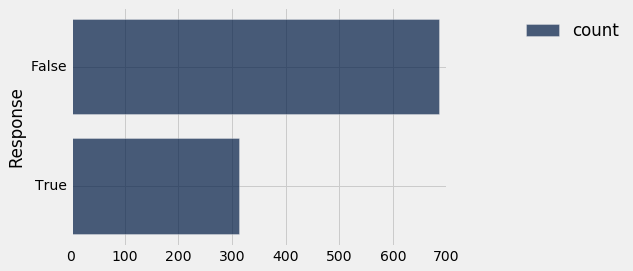

In [36]:
responses.group('Response').barh('Response')

In [37]:
responses.where('Response', False).num_rows

686

In [38]:
responses.where('Response', True).num_rows

314

**Exercise for you:** If `N` out of 1000 responses are `True`, approximately what fraction of the population has truly sung a Justin Bieber song in the shower?

## Analysis

This method is called "randomized response".  It is one way to poll people about sensitive subjects, while still protecting their privacy.  You can see how it is a nice example of randomness at work.

It turns out that randomized response has beautiful generalizations.  For instance, your Chrome web browser uses it to anonymously report feedback to Google, in a way that won't violate your privacy.  That's all we'll say about it for this semester, but if you take an upper-division course, maybe you'll get to see some generalizations of this beautiful technique.

The steps in the randomized response survey can be visualized using a *tree diagram*. The diagram partitions all the survey respondents according to their true and answer and the answer that they eventually give. It also displays the proportions of respondents whose true answers are 1 ("True") and 0 ("False"), as well as the chances that determine the answers that they give. As in the code above, we have used *p* to denote the proportion whose true answer is 1.

![Tree Diagram](../images/rand_response_tree.png)

The respondents who answer 1 split into two groups. The first group consists of the respondents whose true answer and given answers are both 1. If the number of respondents is large, the proportion in this group is likely to be about 2/3 of *p*. The second group consists of the respondents whose true answer is 0 and given answer is 1. This proportion in this group is likely to be about 1/3 of *1-p*.

We can observed $p^*$, the proportion of 1's among the given answers. Thus
$$
p^* ~\approx ~ \frac{2}{3} \times p ~+~ \frac{1}{3} \times (1-p)
$$

This allows us to solve for an approximate value of *p*:
$$
p ~ \approx ~ 3p^* - 1
$$

In this way we can use the observed proportion of 1's to "work backwards" and get an estimate of *p*, the proportion in which whe are interested. 

**Technical note.** It is worth noting the conditions under which this estimate is valid. The calculation of the proportions in the two groups whose given answer is 1 relies on *each of the groups* being large enough so that the Law of Averages allows us to make estimates about how their dice are going to land. This means that it is not only the total number of respondents that has to be large – the number of respondents whose true answer is 1 has to be large, as does the number whose true answer is 0. For this to happen, *p* must be neither close to 0 nor close to 1. If the characteristic of interest is either extremely rare or extremely common in the population, the method of randomized response described in this example might not work well.